## Week 5: Logistic Regression - part II

Instructor: Cornelia Ilin <br>
Email: cilin@ischool.berkeley.edu <br>

#### ``Objectives``

1. Supervised ML: predict multiclass target variables with logistic regression

2. Use AI/ML to predict types of wine cultivars

#### ``Data``

[Source and data description](https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data): these data results from a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars. The analysis determined the quantities of 13 constituents found in each of the three types of wines. The attributes are alcohol, malic acid, ash, alcalinity of ash, magnesium, total phenols, flavonoids, nonflavonoid phenols, proanthocyanins, color intensity, hue, OD280/OD315 of diluted wines, and proline.

We will restrict our attention to two class labels (cultivar 0 and 1) and two features ('alcohol' and 'OD280/OD315_of_diluted_wines') for today's class.

### Step 1: Import packages

In [1]:
# standard libraries
import pandas as pd
import numpy as np
import os
import random

# visualizations
import matplotlib.pyplot as plt
from IPython.display import Image
from mlxtend.plotting import heatmap
from mlxtend.plotting import plot_decision_regions
%matplotlib inline

# sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers

random.seed(2)

### Step 2: Define functions

In [2]:
def read_wine_data():
    """Read the wine dataset from 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'
    # param: None
    # return df and X,y np.arrays for training and test (cleaning included)
    """
    # read data
    df = pd.read_csv('https://archive.ics.uci.edu/'
                          'ml/machine-learning-databases/wine/wine.data',
                          header=None)

    # define columns
    df.columns = ['class_label', 'alcohol', 'malic_acid', 'ash',
                  'alcalinity_of_ash', 'magnesium', 'total_pphenols',
                  'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins',
                  'color_intensity', 'hue', 'OD280/OD315_of_diluted_wines',
                  'proline']

    print('Shape of df wine:', df.shape)
    
    return df

In [3]:
def confusion_matrix_plot(conf_matrix):
    """ Confusion matrix matplotlib plot
    # param conf_matrix: nested list of TP, TN, FP, FN
    # return: None
    """
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.tight_layout()
    plt.show()

In [4]:
def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(3))
    plt.yticks([])
    plt.title('ground truth: ' + str(true_label))
    thisplot = plt.bar(range(3), predictions_array, color="#777777")
    plt.ylim([0, 1])
    
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

---
### Step 3: Read data
---

In [5]:
df = read_wine_data()
df.head()

Shape of df wine: (178, 14)


,class_label,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_pphenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,OD280/OD315_of_diluted_wines,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


The original data contains 178 observations and 13 features.

---
### Step 4: Data preprocessing

---

``labels and features``

In [6]:
# recode class labels (from 0 to 2 instead of 1 to 3)
class_mapping = {label: idx for idx, label in enumerate(np.unique(df.class_label))}
class_mapping

df['class_label'] = df.class_label.map(class_mapping) # notice how we use all 3 classes
labels = ['class_label']

# select only 2 features (easier to visualize features and decission bounderies in a 2D space)
features = ['alcohol', 'OD280/OD315_of_diluted_wines']

# ansamble data
df = df[labels+features]

# print data and shapes
print('Class labels:', df['class_label'].unique())
print('Features:', df.columns[1:])
print('Shape of data', df.shape)
df.head()

Class labels: [0 1 2]
Features: Index(['alcohol', 'OD280/OD315_of_diluted_wines'], dtype='object')
Shape of data (178, 3)


,class_label,alcohol,OD280/OD315_of_diluted_wines
0,0,14.23,3.92
1,0,13.20,3.40
2,0,13.16,3.17
3,0,14.37,3.45
4,0,13.24,2.93


``split data into training and test``

In [7]:
# define outcome #
##################
y = df['class_label'].values

# define features #
###################
X = df[['alcohol', 'OD280/OD315_of_diluted_wines']].values

# split #
#########
# set seed for consistent behavior
np.random.seed(1234)

split = (0.7,0.3) #70% training and 30% test
shuffle = np.random.permutation(np.arange(y.shape[0])) # very important to shuffle the data. Why?
X, y = X[shuffle], y[shuffle]

splits = np.multiply(len(y), split).astype(int) 
X_train, X_test = np.split(X, [splits[0]])
y_train, y_test = np.split(y, [splits[0]])

print('Size of X_train', X_train.shape)
print('Size of y_train', y_train.shape)
print('Size of X_test', X_test.shape)
print('Size of y_test', y_test.shape)


# df for y_train and X_train #
##############################
# easier for EDA later on
df_train = pd.concat(
    [pd.DataFrame(y_train), pd.DataFrame(X_train)],
    axis=1
)

# rename columns
df_train.columns=['class_label', 'alcohol', 'OD280/OD315_of_diluted_wines']

Size of X_train (124, 2)
Size of y_train (124,)
Size of X_test (54, 2)
Size of y_test (54,)


``feature scalling for optimal performance``

standardization: center the feature columns at mean 0 and std 1. Prefered over normalization, as it preservers useful information about outliers and makes the algorithm less sensitive to them. This is what we will be implementing today.

In [8]:
# standardize
sc_x = StandardScaler()

X_train_std = sc_x.fit(X_train).transform(X_train)
X_test_std = sc_x.fit(X_train).transform(X_test)

Note how we fit the StandardScaler() only on the training data, and use the mean and sd parameters to transform the test data!

---
### Step 5: Exploratory Data Analysis (EDA)
---

Prior to training a model it is important to perform exploratory data analysis. The idea is to detect any missing data, the presence of outliers, the feature distribution, and the relationship between features and outcome. Note that typically there is a back and forth between Step 4 and 5, depending on how satisfied you are with the results of the EDA.

In [9]:
df_train.isna().sum()

class_label                     0
alcohol                         0
OD280/OD315_of_diluted_wines    0
dtype: int64

``correlation matrix of outcome and feature variables``

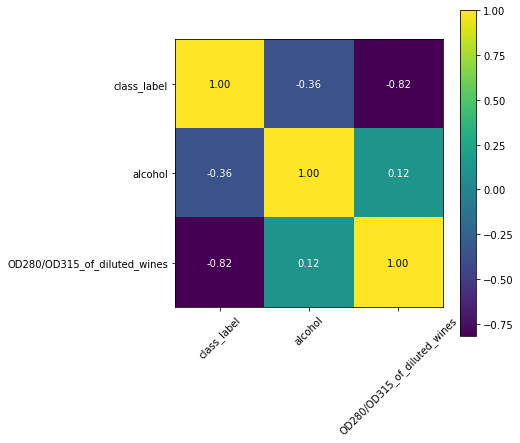

In [10]:
cm = df_train.corr().values
hm = heatmap(
    cm,
    row_names=df_train.columns,
    column_names=df_train.columns,
    figsize=(6, 6)
)

<span style="color:chocolate"> *Question:*</span> Which features seem to be most informative to predict the cultivar class?

``histogram of clases and features``

Here we will examine the distribution of the outcome variable (cultivar class) and the distribution of the two features (alcohol content and ODs of diluted wines).

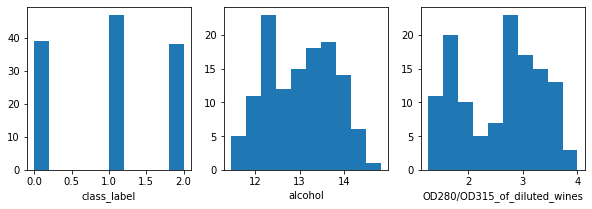

In [11]:
columns = ['class_label', 'alcohol', 'OD280/OD315_of_diluted_wines']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,3))
for idx, ax in enumerate(axes.flatten()):
    # plot histogram
    ax.hist(df_train[columns[idx]])
    # set xlabel
    ax.set_xlabel(columns[idx])

<span style="color:chocolate"> *Question:*</span> As you can see from the histogram, there seems to be some class imbalance in the data. The presence of imbalanced data hampers the detection of rare events as most classification methods implicitly assume an equal occurrence of classes and are designed to maximize the overall classification accuracy. <span style="color:chocolate"> Suggest a way to deal with imbalanced data.</span>

---
### Step 6: Analysis - Logistic Regression with two features
---

``with TensorFlow``

Define and compile model

In [12]:
def build_model(num_features):
    """Return a simple logistic regression model using the Keras Sequential API."""
  # Clear session and set a random seed for consistent behavior.
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)
    

  # Use Keras Sequential API to build a logistic regression
    model = keras.Sequential()
    
    # create input layer
    model.add(tf.keras.Input(shape=(num_features,), name='Input'))
    
    
    
    # create output layer
    model.add(keras.layers.Dense(
          units=3,  # remember it's a multiclass classification problem
          use_bias=True,
          activation='softmax', # remember it's a multiclass classification problem
          kernel_initializer=initializers.RandomNormal(stddev=0.01),
          bias_initializer=initializers.RandomNormal(stddev=0.01),
          name='Output'
    ))
  
  # Use Categorical Crossentropy as our loss and the SGD optimizer.
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
        metrics=['accuracy']
    )
    return model

# Build a model
model = build_model(num_features=len(features))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Output (Dense)              (None, 3)                 9         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


Model fit:

In [13]:
tf.random.set_seed(1234)
np.random.seed(1234)
# Train model
hist= model.fit(x=X_train_std,
                y=y_train,
                #validation_data=[X_test_std, y_test],
                validation_split=0.1, # set 10% of train data for validation
                batch_size=len(X_train_std),
                epochs=20,
                verbose=0 #silence fit
)

Show learned model

In [14]:
# Show learned model
w = model.layers[0].get_weights()[0]
b = model.layers[0].get_weights()[1]

print('Bias:', b)
print('Weights', w)

Bias: [0.00953158 0.01676715 0.00359834]
Weights [[ 0.06510071 -0.06759489  0.01392347]
 [ 0.05457568  0.01297943 -0.06357531]]


Plot model performance:

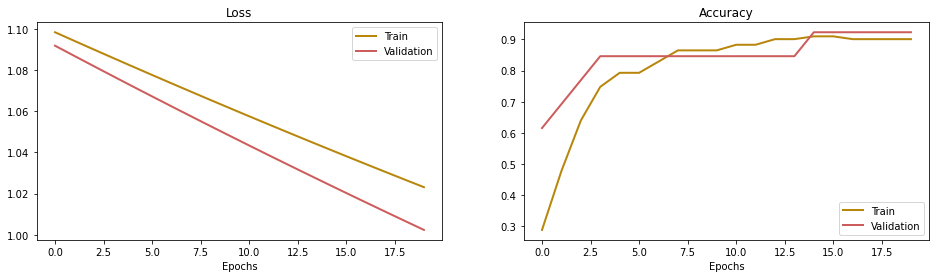

In [15]:
# grab history
history = hist.history

# plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');

# plot accuracy for train and validation
ax = fig.add_subplot(1, 2, 2)
plt.plot(history['accuracy'], lw=2, color='darkgoldenrod')
plt.plot(history['val_accuracy'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Accuracy');

Prediction (on test data)

In [16]:
# run the trained model on the test data (the model outputs probabilities)
y_test_pred_tf = model.predict(x=X_test_std)

# print the predictions for the first example in test data
y_test_pred_tf[0]

array([0.39324775, 0.29588023, 0.310872  ], dtype=float32)

A prediction is an array of 3 numbers. They represent the model's "confidence" that the example corresponds to each of the 3 different cultivar classes. You can see which label has the highest confidence value for the first example in test data:

In [17]:
print("predicted label:", np.argmax(y_test_pred_tf[0]))

predicted label: 0


So, the model is most confident that this example is cultivar 0. Examining the ground truth test label shows that this classification is correct:

In [18]:
# compare with the actual values (ground truth) in test data
print("ground truth label:", np.argmax(y_test[0]))

ground truth label: 0


Next, let's plot the first 15 examples in the test data, their predicted labels, and the true labels.  Color correct predictions in blue and incorrect predictions in red.

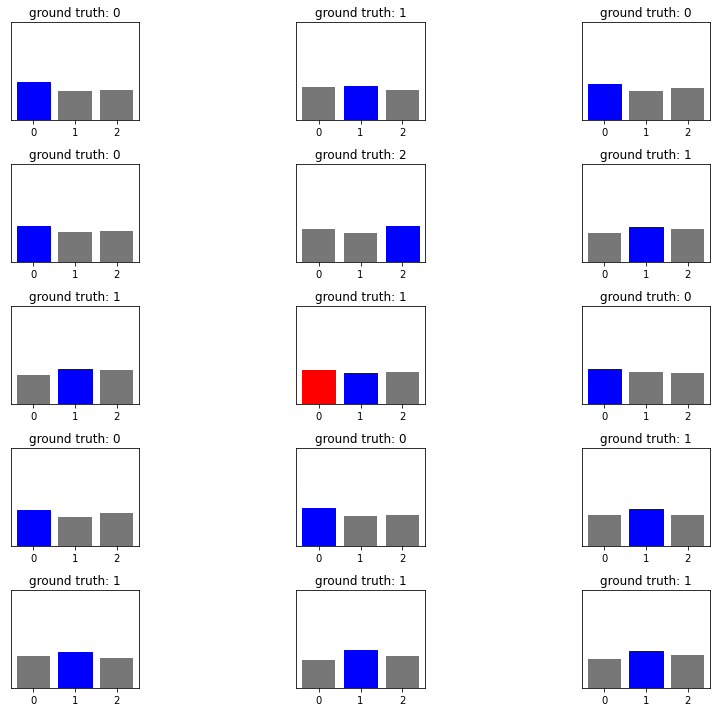

In [19]:
num_rows = 5
num_cols = 3
num_examples = num_rows*num_cols

plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_examples):
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, y_test_pred_tf[i], y_test) # this function is defined at the top of the notebook

    
plt.tight_layout()
plt.show()

Evaluation (on test data)

In [20]:
# print accuracy for test
y_test_pred_tf = model.predict(x=X_test_std)

# set predicted label based on highest probability
y_test_maxpred_tf =  np.argmax(y_test_pred_tf, axis=1)

print('Test, misclassified examples: %d' % (y_test != y_test_maxpred_tf).sum())
error_test_tf = (y_test != y_test_maxpred_tf).sum()/len(y_test_maxpred_tf)
print('Test, prediction accuracy: %.3f'% (1-error_test_tf))

Test, misclassified examples: 5
Test, prediction accuracy: 0.907


In [21]:
# plot confusion matrix
conf_matrix = tf.math.confusion_matrix(
    y_test,
    y_test_maxpred_tf,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)
conf_matrix

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[19,  1,  0],
       [ 1, 20,  3],
       [ 0,  0, 10]], dtype=int32)>

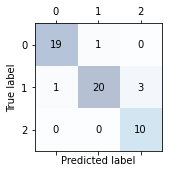

In [22]:
confusion_matrix_plot(conf_matrix.numpy())

<span style="color:chocolate"> *Question:*</span> Which class is the most difficult for the Logistic Regression model to recognize?